In [1]:
%%capture

import pandas as pd
import numpy as np
import datetime
import pyspark as psk
import itertools
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller #Check stationarity by running ADF Test
from statsmodels.graphics.tsaplots import plot_acf #autoregressive correlation function for initial P value
from statsmodels.graphics.tsaplots import plot_pacf #partial autoregressive correlation function for initial Q value
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


## Goal of Challenge:
- Predict the 7-day average of new COVID-19 cases and that of the positivity rate based on the historical public health data.

#### <u> Report </u>: predictions for the 1-week prediction period (Sep. 27, 2021 – Oct. 4, 2021)

1. Daily new cases for the 1-week prediction period 
2. 7-day average of daily new cases for every 7-day window ending on each day of the 1-week prediction period 
3. Daily positivity rate for the 1-week prediction period 
4. 7-day average of the positivity rate for every 7-day window ending on each day of the 1-week prediction period Along with these future predictions
5. report how accurately trained models were able to fit the historical data for the 4-week period ending on the submission date (Aug. 30, 2021 – Sep. 26, 2021). 

##### <u> Evaluation </u>: 
1. How accurately is the predictive model able to model the trends in the past? 
2. How accurately can the model predict future trends for the next 1-week period?

In [34]:
%%capture

states = pd.DataFrame( pd.read_csv('states.csv') )
cbsas = pd.DataFrame(pd.read_csv('cbsas.csv'))
counties = pd.DataFrame(pd.read_csv('counties.csv'))

#this additional Data was downloaded from the covid Act Now website
state_historical = pd.DataFrame(pd.read_csv('states.timeseries.csv')) 

In [4]:
state_historical.head(5)

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,actuals.hsaIcuBeds.currentUsageCovid,metrics.bedsWithCovidPatientsRatio,hsaName,actuals.hospitalBeds.weeklyCovidAdmissions,actuals.hsaHospitalBeds.weeklyCovidAdmissions,metrics.weeklyCovidAdmissionsPer100k,communityLevels.cdcCommunityLevel,communityLevels.canCommunityLevel,actuals.vaccinationsFall2022BivalentBooster,metrics.vaccinationsFall2022BivalentBoosterRatio
0,2020-03-01,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
%%capture
# I created a function that lets me profile the data and observe corelations

def file_prof(fileX, htmlX):
    filex_profile = ProfileReport(fileX)
    html_name = f"{htmlX}.html"
    filex_profile.to_file(html_name)

In [6]:
%%capture

#This cell ran, will provile the CSV files to an interactive html
'''file_prof(states, 'state_prof')
file_prof(cbsas, 'cbsas_prof')
file_prof(gmr, 'gmr_prof')
file_prof(counties, 'counties_prof')'''


In [8]:
#convert date column to dtype: datetime. 
state_historical['date']= state_historical['date'].astype('datetime64[ns]')

# Vector AutoRegression

##### I used the VAR model due to the  multivariate nature of the curated data

* The data used to train is a combination of data from the global modility rate file and the historical state file.
* I preprocessed both files, filtered them for the state of colorado and merged them together.


In [9]:

sample_historical = state_historical[['date', 'country','state','metrics.infectionRate','actuals.newCases']]


In [10]:
#Here the data is filtered for the dates given

sample_historical = sample_historical[(sample_historical['date'] >= '2021-08-30') & (sample_historical['date']<= '2021-09-26')]


In [11]:
#here the data is filtered for the the state of Colorado
sample_historical_co = sample_historical[sample_historical['state']=='CO']

In [12]:
#View of our Data

sample_historical_co

,date,country,state,metrics.infectionRate,actuals.newCases
7109,2021-08-30,US,CO,1.10,3076.0
7110,2021-08-31,US,CO,1.09,2104.0
7111,2021-09-01,US,CO,1.08,1604.0
7112,2021-09-02,US,CO,1.08,2873.0
7113,2021-09-03,US,CO,1.07,2118.0
7114,2021-09-04,US,CO,1.06,NaN
7115,2021-09-05,US,CO,1.05,928.0
7116,2021-09-06,US,CO,1.04,3578.0
7117,2021-09-07,US,CO,1.04,1930.0
7118,2021-09-08,US,CO,1.03,2083.0


In [13]:
#Reading the Global Mobility data for 2021
gmr_2021 = pd.DataFrame(pd.read_csv('2021_US_Region_Mobility_Report.csv'))

In [14]:
#filtering global molity data for the state of Colorado
gmr_2021_CO = gmr_2021[gmr_2021['iso_3166_2_code']=='US-CO']

In [15]:
%%capture

#PReprocessing the column. Changing the sting from 'US-CO to 'CO''
gmr_2021_CO['iso_3166_2_code'] = gmr_2021_CO['iso_3166_2_code'].str.split('-').str[-1]

In [16]:
#Selecting the features we need
gmr_2021_CO = gmr_2021_CO[['country_region_code','iso_3166_2_code','date','retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']]

In [17]:
%%capture
#Converting to dtype: datetime
gmr_2021_CO['date'] = gmr_2021_CO['date'].astype('datetime64[ns]')

In [18]:
%%capture

#Changing the name of a column to prefered one for joinning the data togehter
gmr_2021_CO.rename(columns={'iso_3166_2_code':'state'}, inplace=True)

In [19]:
#Merge Global mobility data with historical Date

CO_data = pd.merge(sample_historical_co,gmr_2021_CO, on=['date','state'])
train_data_co = CO_data.copy()


In [20]:
#Details on the Feature Engineered dataframe
train_data_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 12 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                28 non-null     datetime64[ns]
 1   country                                             28 non-null     object        
 2   state                                               28 non-null     object        
 3   metrics.infectionRate                               28 non-null     float64       
 4   actuals.newCases                                    27 non-null     float64       
 5   country_region_code                                 28 non-null     object        
 6   retail_and_recreation_percent_change_from_baseline  28 non-null     float64       
 7   grocery_and_pharmacy_percent_change_from_baseline   28 non-null     float64       
 8   parks_percen

In [25]:
#Fixing NaNs
train_data_co['actuals.newCases'].fillna(0, inplace=True)

In [ ]:
#Changing the index to date column
train_data_co = train_data_co.set_index('date')

### Final Feature engineering

###### Columns to predict on :
        - retail_and_recreation_percent_change_from_baseline
        - grocery_and_pharmacy_percent_change_from_baseline
        - parks_percent_change_from_baseline
        - transit_stations_percent_change_from_baseline
        - workplaces_percent_change_from_baseline
        - residential_percent_change_from_baseline
        - Infection Rate
        - New Cases'

In [27]:
#Colorado Data Frame is filtered to keep only continious data
co_cont_data = train_data_co[['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline','metrics.infectionRate','actuals.newCases']] #All Continious data

### Model Training with historical data from the period of: Aug. 30, 2021 – Sep. 26, 2021

In [28]:
%%capture
#Setting Initial Parameters for the VAR Model

lag_order = 2 #The lag order is randomly select for a first try
var_model = VAR(co_cont_data)
trained_var = var_model.fit(lag_order)


### Predicting for the period of [ Sep. 27, 2021 – Oct. 4, 2021 ]

In [29]:
#Forcasting for the 7 day period
seven_day_forecast = trained_var.forecast(co_cont_data.values[-lag_order:], steps=7)

#slicing and saving the forcated data
new_cases_forecasts = seven_day_forecast[:, co_cont_data.columns.get_loc('actuals.newCases')]

#round the result to 2 point decimal
new_cases_forecasts = np.round(new_cases_forecasts,2)

### Model Evaluation

In [30]:
#Curating an evaluation data set. 
prediction_test = state_historical[['date', 'country','state','metrics.infectionRate','actuals.newCases']]

#Date Filtering
prediction_test_date = prediction_test[(prediction_test['date'] >= '2021-09-27') & (prediction_test['date']< '2021-10-04')]

#State Filtering
prediction_test_date_co = prediction_test_date[prediction_test_date['state']=='CO']

#Index Setting
prediction_test_date_co = prediction_test_date_co.set_index('date')

#Adding predicted Value to the evaluation dataset
prediction_test_date_co['predicted']= new_cases_forecasts

In [35]:
prediction_test_date_co.to_csv('prediction.csv')

##### Metrics Calculation

In [31]:
pred_rsme = round(np.sqrt(mean_squared_error(prediction_test_date_co['actuals.newCases'],prediction_test_date_co['predicted'])),2)

## Root Mean Square Error: 

In [32]:
pred_rsme

1023.63

### Visualize the Actual and Predicted Values

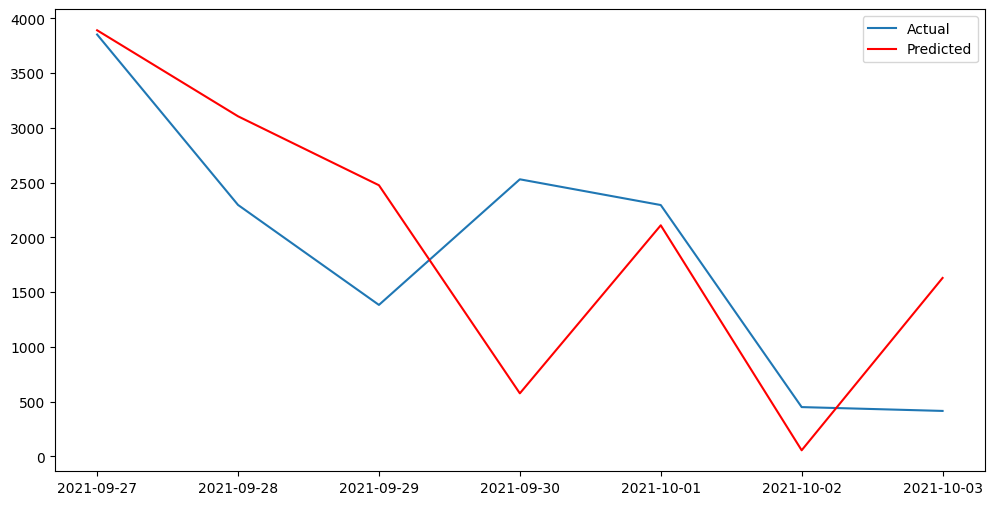

In [33]:
plt.figure(figsize=(12,6))

plt.plot(prediction_test_date_co['actuals.newCases'], label='Actual')
plt.plot(prediction_test_date_co['predicted'], color='red', label='Predicted')
plt.legend()
plt.show()

###  Lag and VAR Model Optimization

In [45]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic
''' We use Akaike Information Criterion (AIC) to determine the most suitable lag order for our VAR model.
Bayesian Information Criterion (BIC) can also be used. The choice depends on the user's preference. '''

#Defining a function to find the optimal lag for VAR

def optimal_lag_var (x,data_x):

    aic_final_values = []

    for i in range(1, x+1):    

        #fitting a VAR model for every number the given range
        model_evaluation = VAR(data_x)
        model_evaluation_fited = model_evaluation.fit(i)

        #calcution of aic for every lag in the given range
        aic_score = model_evaluation_fited.aic

        #store the lag order with its respective aic value

        aic_final_values.append((i, aic_score))
    
    return aic_final_values


In [51]:
%%capture
#run the function to choose the best lag oder in a range of 1 to 10 incluse

aic_results = optimal_lag_var(10,co_cont_data)

In [121]:
#Write a function to choose the best lag order
def lag_finder(result_x):
    b = [] #empty list for storing the lag order we want
    for i in result_x:
        if i[1]> 0:
            b.append(i)
    return min(b[1])


In [124]:
#run the function to give us the lag
optimized_lag = lag_finder(aic_results)
optimized_lag


2

The Optimal Lag number in this case is the same as what i used when runing the first prediction. No futher change to the model is required at this point. 